## Projet 6 : Classifiez automatiquement des biens de consommation

- Consignes : https://openclassrooms.com/fr/projects/631/assignment
- Données : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip
- Documentation API Amazon : https://docs.aws.amazon.com/fr_fr/AWSECommerceService/latest/DG/ItemSearch.html
##### Etude de faisabilité du moteur de classification

Votre mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

Pour ce faire, vous allez évaluer la possibilité d'extraire des données depuis l'API Amazon en prenant connaissance de la documentation et en écrivant la requête qui vous permettrait d'extraire des données supplémentaires. Vous vous assurerez ainsi que vous pourrez bien disposer de plus de données et diversifier les sources de données pour éviter les biais pour votre moteur de classification.

##### Contraintes

Linda vous a communiqué les contraintes suivantes :

- Limiter le nombre d’articles pris par l’API (par exemple : 1000 lignes) et filtrer sur un unique type d’article (par exemple un type d’article peu présent dans votre échantillon de données actuelles).
- Afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.
- Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration.

## Première Partie : Pretraitement_feature_extraction_faisaibilite


### Importation des Packages

In [2]:
pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/fb/c8/9790df08b2685bf931e940fdf1207b39f394dc28b033c603f04d7e8da0cf/wordcloud-1.9.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.8/159.8 kB 8.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importation des bibliothèques nécessaires
import pandas as pd  # Pour la manipulation de données sous forme de DataFrames
import numpy as np   # Pour la manipulation de tableaux numériques
import matplotlib.pyplot as plt  # Pour la création de graphiques
import seaborn as sns  # Pour des visualisations de données plus avancées

# Importation de la bibliothèque Natural Language Toolkit (NLTK)
import nltk

# Importation de l'outil VADER pour l'analyse de sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Importation des arrêts (stop words) de la langue anglaise
from nltk.corpus import stopwords

# Importation de l'outil de tokenization de mots
from nltk.tokenize import word_tokenize

# Importation de l'outil de lemmatization des mots
from nltk.stem import WordNetLemmatizer

# Importation des outils pour la préparation des données
from sklearn.model_selection import train_test_split  # Pour diviser les données en ensembles d'entraînement et de test
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Pour la vectorisation du texte

# Importation de bibliothèques pour la manipulation de texte
import re   # Pour les expressions régulières (regex)
import string   # Pour la manipulation de chaînes de caractères

# Importation de la bibliothèque WordCloud pour la création de nuages de mots
from wordcloud import WordCloud
from wordcloud import STOPWORDS  # Les mots à exclure lors de la création du nuage de mots

# Importation de l'encodeur d'étiquettes pour la conversion des étiquettes de texte en nombres
from sklearn.preprocessing import LabelEncoder

# Importation d'outils pour la visualisation et l'analyse de texte
from sklearn.manifold import TSNE  # Pour la réduction de dimension TSNE
from gensim.models import word2vec  # Pour la création de modèles de mots
from sklearn.cluster import KMeans  # Pour la clustering des données

# Désactivation des avertissements (warnings)
import warnings
warnings.filterwarnings('ignore')

### Description des données
#### Chargement des datasets
Nous allons importer l'ensemble des jeux de données afin de visualiser leurs principales informations :

In [5]:
# On affiche le chemin menant à nos datasets.
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
# Affichage du DataFrame (df)
df.head(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [6]:
# Affiche des informations essentielles sur le DataFrame 'df'.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Text(0.5, 1.0, 'Répartition des produits en fonction de leur marque')

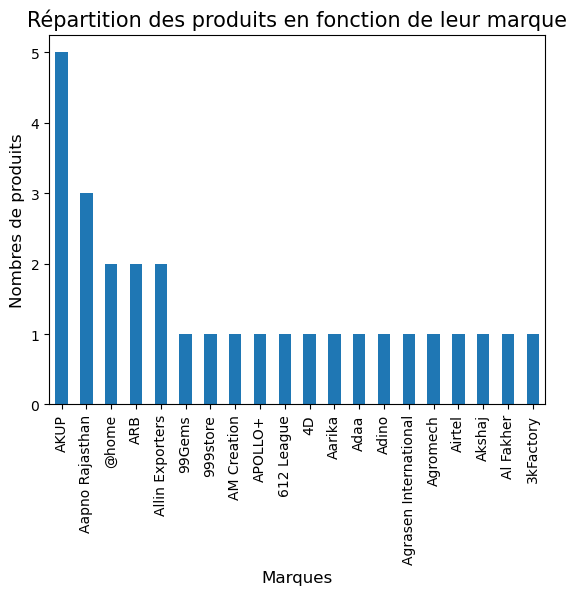

In [7]:
# Regroupement des données par marque et comptage du nombre de produits par marque
df_groups = df.groupby(['brand'])['product_name'].count()[:20].sort_values(ascending=False)
# Création d'un graphique en barres pour visualiser la répartition des produits par marque
df_groups.plot(kind='bar')
# Définition du libellé de l'axe des x (abscisses)
plt.xlabel('Marques' , fontsize = 12)
# Définition du libellé de l'axe des y (ordonnées)
plt.ylabel('Nombres de produits', fontsize = 12)
# Définition du titre du graphique
plt.title("Répartition des produits en fonction de leur marque", fontsize = 15)
# Affichage du graphique
plt.show()

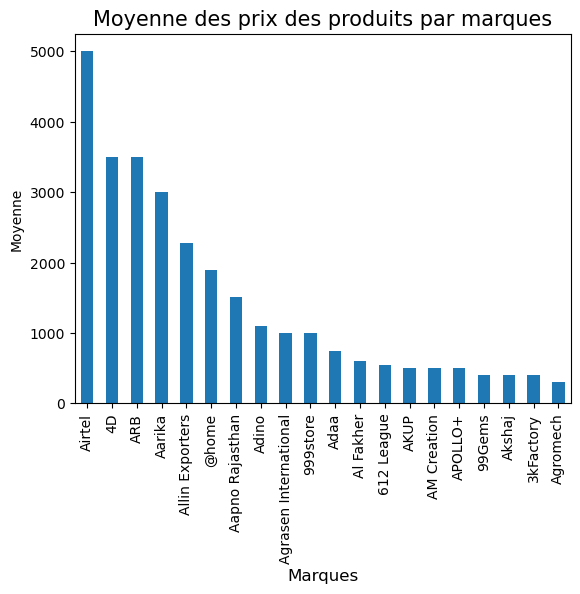

In [8]:
# Regroupement des données par marque et calcul de la moyenne des prix de détail par marque
df_groupp= df.groupby(['brand'])['retail_price'].mean()[:20].sort_values(ascending=False)
# Création d'un graphique en barres pour visualiser la moyenne des prix par marque
df_groupp.plot(kind='bar')
# Définition du libellé de l'axe des x (abscisses)
plt.xlabel('Marques' , fontsize = 12)
# Définition du libellé de l'axe des y (ordonnées)
plt.ylabel('Moyenne', fontsize = 10)
# Définition du titre du graphique
plt.title('Moyenne des prix des produits par marques', fontsize = 15);
# Affichage du graphique
plt.show()

In [9]:
# La boucle for parcourt les éléments de la colonne 'product_category_tree' pour les 10 premières lignes.
for index,text in enumerate(df['product_category_tree'][10:20]):
# L'indice 'index' correspond à la position de l'élément actuel dans la boucle, et 'text' contient la valeur de la colonne.

# Affiche l'index du produit actuel (décalé de 1 pour commencer à partir de 1 au lieu de 0) et le texte de la colonne 'product_category_tree'.
  print('Produit %d:\n'%(index+1),text)

Produit 1:
 ["Watches >> Wrist Watches >> Calibro Wrist Watches"]
Produit 2:
 ["Watches >> Wrist Watches >> Cartier Wrist Watches"]
Produit 3:
 ["Watches >> Wrist Watches >> Lois Caron Wrist Watches"]
Produit 4:
 ["Watches >> Wrist Watches >> Titan Wrist Watches"]
Produit 5:
 ["Watches >> Wrist Watches >> Srushti Art Jewelry Wrist Watches"]
Produit 6:
 ["Watches >> Wrist Watches >> Escort Wrist Watches"]
Produit 7:
 ["Watches >> Wrist Watches >> Jack klein Wrist Watches"]
Produit 8:
 ["Watches >> Wrist Watches >> North Moon Wrist Watches"]
Produit 9:
 ["Watches >> Wrist Watches >> Franck Bella Wrist Watches"]
Produit 10:
 ["Watches >> Wrist Watches >> Ridas Wrist Watches"]


In [10]:
# Crée une nouvelle colonne 'categorie' en appliquant une fonction lambda à chaque élément de la colonne 'product_category_tree'
df['categorie'] = df['product_category_tree'].apply(lambda x: x.split('>>')[0].split('["')[1])
# Affiche les valeurs uniques de la nouvelle colonne 'categorie'
df['categorie'].unique()

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [11]:
# Affiche les deux premières lignes du DataFrame df
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care


In [12]:
# Définition d'une fonction to_strip pour supprimer les espaces excessifs entre les mots
def to_strip(text):
    return " ".join(text.split())
# Applique la fonction to_strip à chaque élément de la colonne 'categorie' du DataFrame
df['categorie'] = df['categorie'].apply(to_strip)
# Affiche les valeurs uniques de la colonne 'categorie' après le nettoyage
df['categorie'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [13]:
# Affiche les deux premières lignes du DataFrame df
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categorie
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care


In [14]:
# Calcule le nombre d'occurrences de chaque valeur unique dans la colonne 'categorie'
df['categorie'].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: categorie, dtype: int64

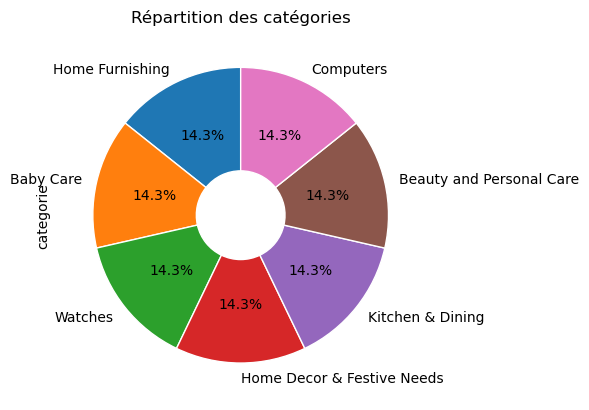

In [15]:
# Calcule le nombre d'occurrences de chaque valeur unique dans la colonne 'categorie'
df['categorie'].value_counts().plot(
    kind='pie',
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.7,
                    edgecolor='w'),
    title = "Répartition des catégories");

In [16]:
# Crée une nouvelle colonne 'categorie2' en appliquant une fonction lambda à chaque élément de la colonne 'product_category_tree'
df['categorie2'] = df['product_category_tree'].apply(lambda x: x.split('>>')[1])
# Affiche les valeurs uniques de la nouvelle colonne 'categorie2'
df['categorie2'].unique()

array([' Curtains & Accessories ', ' Baby Bath & Skin ', ' Bed Linen ',
       ' Wrist Watches ', ' Living Room Furnishing ', ' Bath Linen ',
       ' Candles & Fragrances ', ' Tableware & Cutlery ', ' Lighting ',
       ' JMD Home Furnishing ', ' Infant Wear ',
       " Kripa's Home Furnishing ", ' Hair Care ', ' Coffee Mugs ',
       ' Network Components ', ' Tablet Accessories ', ' Cookware ',
       ' Laptop Accessories ', ' Makeup ', ' Combos and Kits ',
       ' Feeding & Nursing ', ' Baby Bedding ',
       ' Kitchen & Dining Linen ', ' Containers & Bottles ',
       ' Consumables & Disposables ', ' Wall Decor & Clocks ',
       ' Table Decor & Handicrafts ', ' Flowers, Plants & Vases ',
       ' Software ', ' Showpieces ', ' Furniture & Furnishings ',
       ' Decorative Lighting & Lamps ', ' Baby Grooming ',
       ' Computer Peripherals ', ' Cushions, Pillows & Covers ',
       ' Storage ', ' Health Care ', ' Body and Skin Care ',
       ' Kitchen Tools ', ' TRUE Home Decor & 

In [17]:
# Applique la fonction to_strip à chaque élément de la colonne 'categorie2' du DataFrame
df['categorie2'] = df['categorie2'].apply(to_strip)

Text(0, 0.5, 'Nombre de produits')

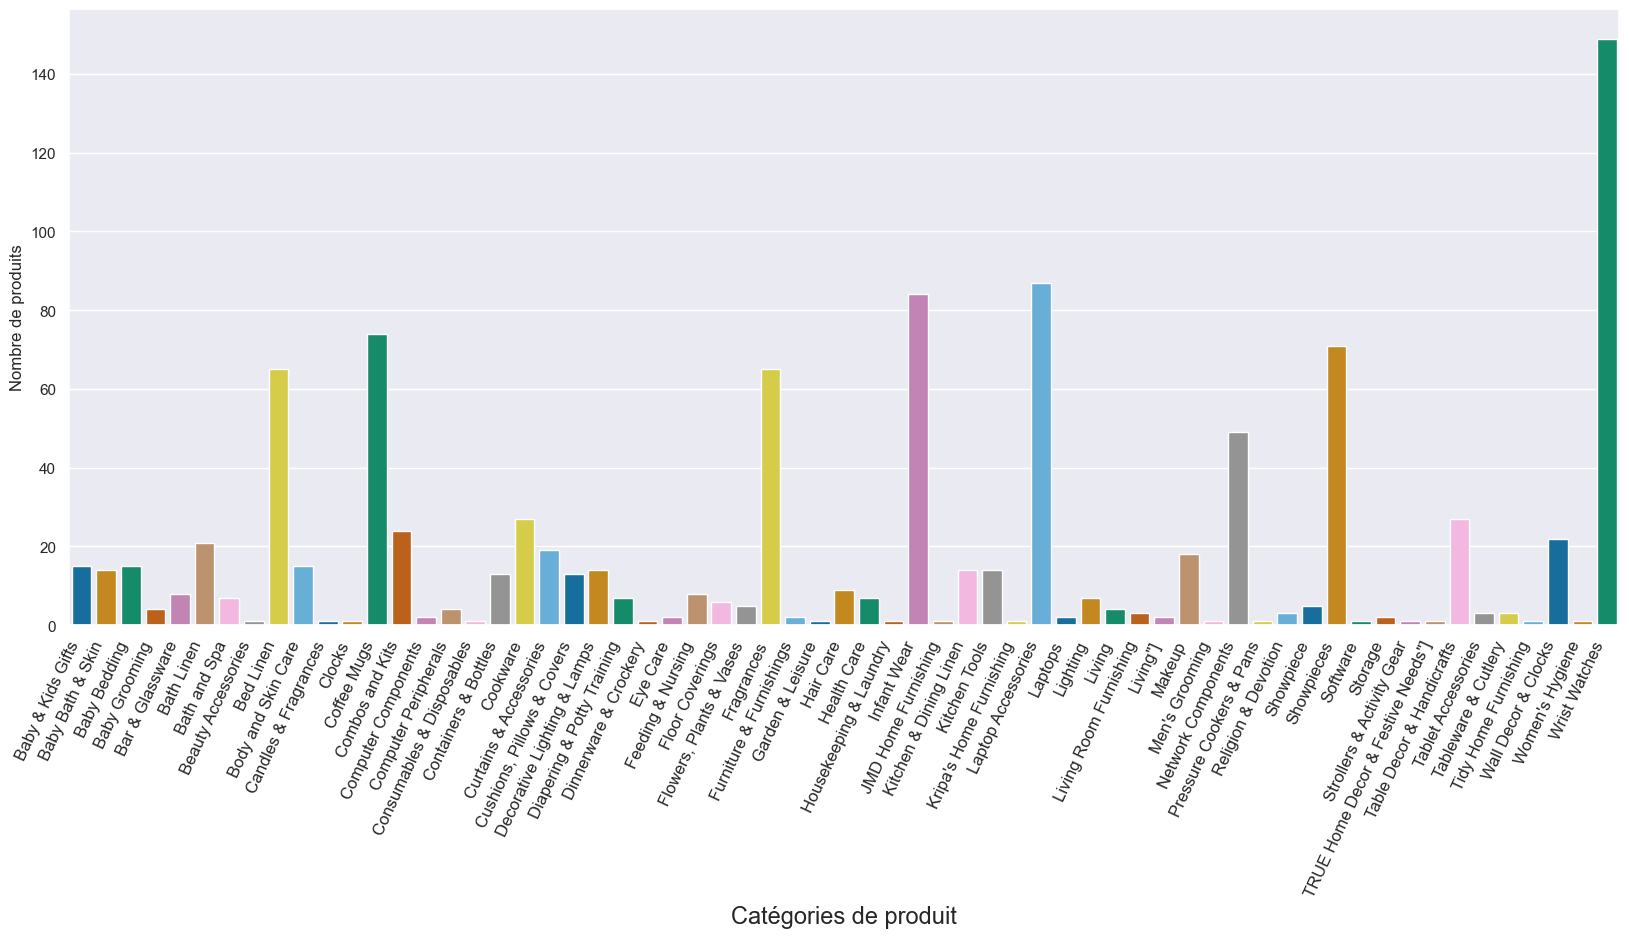

In [18]:
# Définition de la taille globale de la figure
sns.set(rc = {'figure.figsize':(20,8)})
sns.barplot(x=df.groupby(['categorie2']).size().index, # Les catégories de produits
            y=df.groupby(['categorie2']).size(),  # Le nombre de produits dans chaque catégorie
            palette='colorblind',)  # Palette de couleurs

# Personnalisation de l'apparence du graphique
plt.xticks(rotation = 65, ha = 'right', size = 12)  # Rotation des étiquettes sur l'axe des x, alignées à droite
plt.xlabel('Catégories de produit', size=17)  # Titre de l'axe des x
plt.ylabel('Nombre de produits',  size=12)   # Titre de l'axe des y

# Affichage du graphique
plt.show()

### Nettoyage de la colonne 'description'

In [19]:
# Crée une copie du DataFrame df et la stocke dans une nouvelle variable df_clean
df_clean = df.copy()

In [20]:
# Calcule le nombre de mots dans chaque description et stocke le résultat dans la colonne 'res'
df_clean['res']= df_clean['description'].str.count(' ') + 1
# Affiche la colonne 'res', qui contient le nombre de mots pour chaque description
df_clean['res']

0       230
1        74
2       215
3       145
4       214
       ... 
1045    431
1046    303
1047     37
1048     31
1049     29
Name: res, Length: 1050, dtype: int64

In [21]:
# Regroupe les données par catégorie ('categorie') et calcule la moyenne du nombre de mots ('res')
cat = df_clean.groupby('categorie').mean()['res']
# Affiche la série résultante contenant la moyenne du nombre de mots pour chaque catégorie
cat

categorie
Baby Care                      80.146667
Beauty and Personal Care       60.513333
Computers                      89.806667
Home Decor & Festive Needs     99.026667
Home Furnishing                65.113333
Kitchen & Dining              112.880000
Watches                        54.766667
Name: res, dtype: float64

In [22]:
# Calcule la moyenne des valeurs dans la série 'cat'
cat.mean()

80.32190476190476

In [23]:
# La boucle for parcourt les descriptions des produits pour les lignes de la 26e à la 40e.
for index,text in enumerate(df_clean.description[25:40]):
# L'indice 'index' correspond à la position de l'élément actuel dans la boucle, et 'text' contient la valeur de la colonne 'description'.
    
# Affiche l'index du produit actuel (décalé de 1 pour commencer à partir de 1 au lieu de 0) et la description du produit.
  print('Produit %d:\n'%(index+1),text)

Produit 1:
 Alfajr WQ18 Qibla Compass Digital Watch  - For Men, Boys, Girls - Buy Alfajr WQ18 Qibla Compass Digital Watch  - For Men, Boys, Girls  WQ18 Online at Rs.7495 in India Only at Flipkart.com. Qibla Compass, Light, Azan Time Calculation - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
Produit 2:
 Disney 98189 Analog Watch  - For Boys, Girls - Buy Disney 98189 Analog Watch  - For Boys, Girls  98189 Online at Rs.900 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
Produit 3:
 Disney DW100405 Digital Watch  - For Boys - Buy Disney DW100405 Digital Watch  - For Boys  DW100405 Online at Rs.1345 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
Produit 4:
 Vizion 8502-7PURPLE Sports Series Digital Watch  - For Boys, Girls
                         Price: Rs. 5

In [24]:
#nltk.download('stopwords')

In [25]:
#nltk.download('all')

In [26]:
# Importe la classe WordNetLemmatizer du module nltk.stem
from nltk.stem import WordNetLemmatizer 

# Crée une instance de WordNetLemmatizer pour effectuer la lemmatisation
lemmatizer = WordNetLemmatizer() 

# Importe la liste des mots vides (stop words) de la langue anglaise depuis nltk
stop_words = stopwords.words('english')

# Définit une fonction de prétraitement appelée process_clean
def process_clean(text):
    # Supprime tous les caractères spéciaux et non alphabétiques du texte
    new_text = re.sub("[^a-zA-Z]", " ",text) 
    
  # Convertit toutes les lettres en minuscules
    words = new_text.lower().split()
    
   # Supprime les mots vides (stop words) de la liste stop_words
    words = [w for w in words if not w in stop_words] 
    
   # Effectue la lemmatisation sur chaque mot
    words = [lemmatizer.lemmatize(word) for word in words]
    
  # Reconstitue les mots en une seule chaîne de caractères
    return (" ".join(words))

In [27]:
# Applique la fonction process_clean à chaque élément de la colonne 'description'
df_clean['clean_description']=df_clean.description.apply(lambda x: process_clean(x))

In [28]:
# La boucle for parcourt les descriptions de produits nettoyées et prétraitées
# pour les lignes de la 26e à la 40e.
for index,text in enumerate(df_clean.clean_description[25:40]):
 # L'indice 'index' correspond à la position de l'élément actuel dans la boucle, 
    # et 'text' contient la valeur de la colonne 'clean_description'.    
    
# Affiche l'index du produit actuel (décalé de 1 pour commencer à partir de 1 au lieu de 0) 
    # et la description nettoyée et prétraitée du produit.
  print('Produit %d:\n'%(index+1),text)

Produit 1:
 alfajr wq qibla compass digital watch men boy girl buy alfajr wq qibla compass digital watch men boy girl wq online r india flipkart com qibla compass light azan time calculation great discount genuine product day replacement guarantee free shipping cash delivery
Produit 2:
 disney analog watch boy girl buy disney analog watch boy girl online r india flipkart com great discount genuine product day replacement guarantee free shipping cash delivery
Produit 3:
 disney dw digital watch boy buy disney dw digital watch boy dw online r india flipkart com great discount genuine product day replacement guarantee free shipping cash delivery
Produit 4:
 vizion purple sport series digital watch boy girl price r brand vizion sport series watch kid year manufacturer warranty digital display automatic movement metal case solid body dial shape round dial dimension mm strap material silicone strap width mm water resistant night display cold backlight daily alarm hour minute second date week

In [29]:
# Extrait les valeurs de la colonne 'clean_description' et les convertit en une liste
df_clean['clean_description'].to_list()

['key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain cm height pack price r curtain enhances look interior curtain made high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight specification elegance polyester multicolor abstract eyelet door curtain cm height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id duster color multicolor dimension length cm box number conten

In [30]:
# Calcule le nombre de mots dans chaque description nettoyée et prétraitée
df_clean['res_clean']= df_clean['clean_description'].str.count(' ') + 1

# Affiche la colonne 'res_clean', qui contient le nombre de mots pour chaque description
df_clean['res_clean']

0       152
1        62
2       154
3       114
4       153
       ... 
1045    226
1046    154
1047     30
1048     24
1049     22
Name: res_clean, Length: 1050, dtype: int64

In [31]:
# Regroupe les données par catégorie ('categorie') et calcule la moyenne du nombre de mots nettoyés ('res_clean')
cat_clean = df_clean.groupby('categorie').mean()['res_clean']
# Affiche la série résultante contenant la moyenne du nombre de mots nettoyés pour chaque catégorie
cat_clean

categorie
Baby Care                     59.380000
Beauty and Personal Care      43.526667
Computers                     64.106667
Home Decor & Festive Needs    61.826667
Home Furnishing               44.346667
Kitchen & Dining              68.100000
Watches                       38.226667
Name: res_clean, dtype: float64

In [32]:
# Calcule la moyenne des valeurs dans la série 'cat_clean'
cat_clean.mean()

54.21619047619048

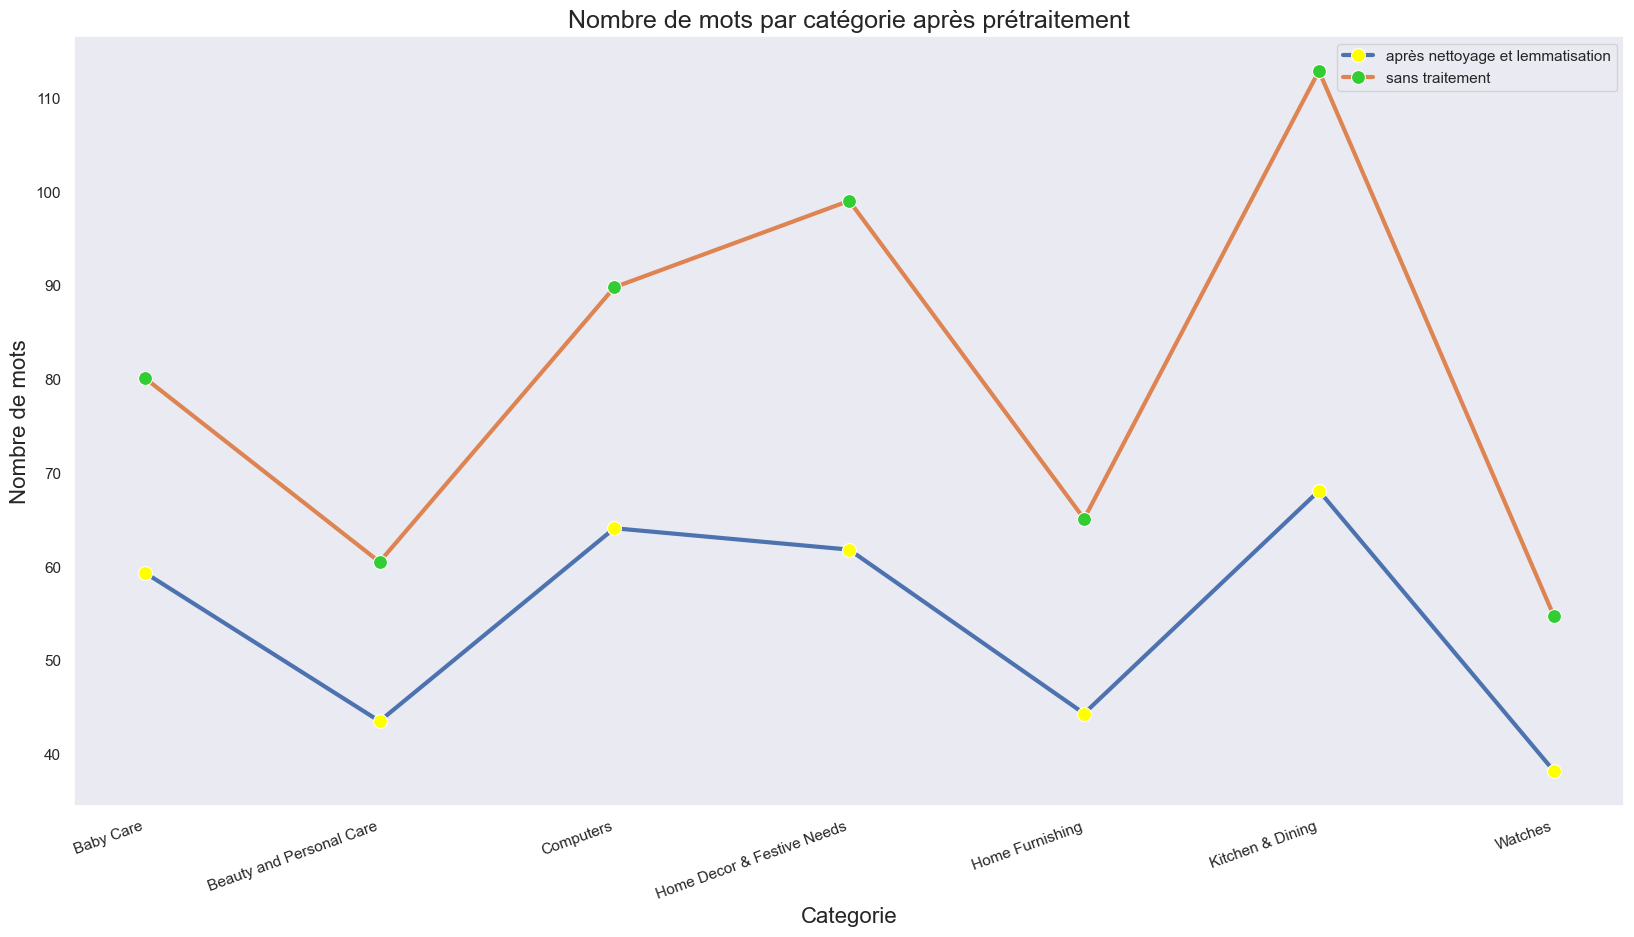

In [33]:
# Crée une figure pour le graphique avec une taille spécifiée
plt.figure(figsize=(20,10))

# Trace un graphique linéaire (ligne) pour les données après nettoyage et lemmatisation
sns.lineplot(x=cat_clean.index,
             y=cat_clean,
             linewidth=3,
             marker='o',
             markersize=10,
             markerfacecolor='yellow',
             label='après nettoyage et lemmatisation')

# Trace un graphique linéaire (ligne) pour les données sans traitement
sns.lineplot(x=cat.index,
             y=cat,
             linewidth=3,
             marker='o',
             markersize=10,
             markerfacecolor='limegreen',
             label='sans traitement')
# Ajoute une légende pour distinguer les deux lignes
plt.legend()
# Définit les étiquettes des axes x et y ainsi que le titre du graphique
plt.xlabel('Categorie',fontsize=16)
plt.xticks(rotation=20,ha='right')  # Rotation des étiquettes de l'axe x pour une meilleure lisibilité
plt.ylabel('Nombre de mots',fontsize=16)
plt.title('Nombre de mots par catégorie après prétraitement', fontsize=18)

# Affiche une grille pour une meilleure référence visuelle
plt.grid()
# Affiche le graphique
plt.show()

In [34]:
# Calcule la différence en pourcentage entre la moyenne après prétraitement et la moyenne sans traitement
diff_percentage = 100-round(cat_clean.mean() / cat.mean()*100)

33

In [35]:
# Importe la classe FreqDist de la bibliothèque nltk.probability
from nltk.probability import FreqDist

# Crée une liste vide appelée 'all_words' pour stocker tous les mots des descriptions
all_words = []

# Parcours chaque description dans la colonne 'clean_description' du DataFrame df_clean
for i in df_clean['clean_description']:
    # La méthode .split() est utilisée pour diviser chaque description en mots individuels
    # Les mots sont ensuite ajoutés à la liste 'all_words'
    all_words.extend(i.split())
# Utilise FreqDist pour calculer la distribution de fréquence des mots
nltk.FreqDist(all_words)

FreqDist({'r': 933, 'product': 864, 'free': 618, 'cm': 595, 'buy': 581, 'delivery': 567, 'genuine': 564, 'shipping': 564, 'cash': 564, 'price': 561, ...})

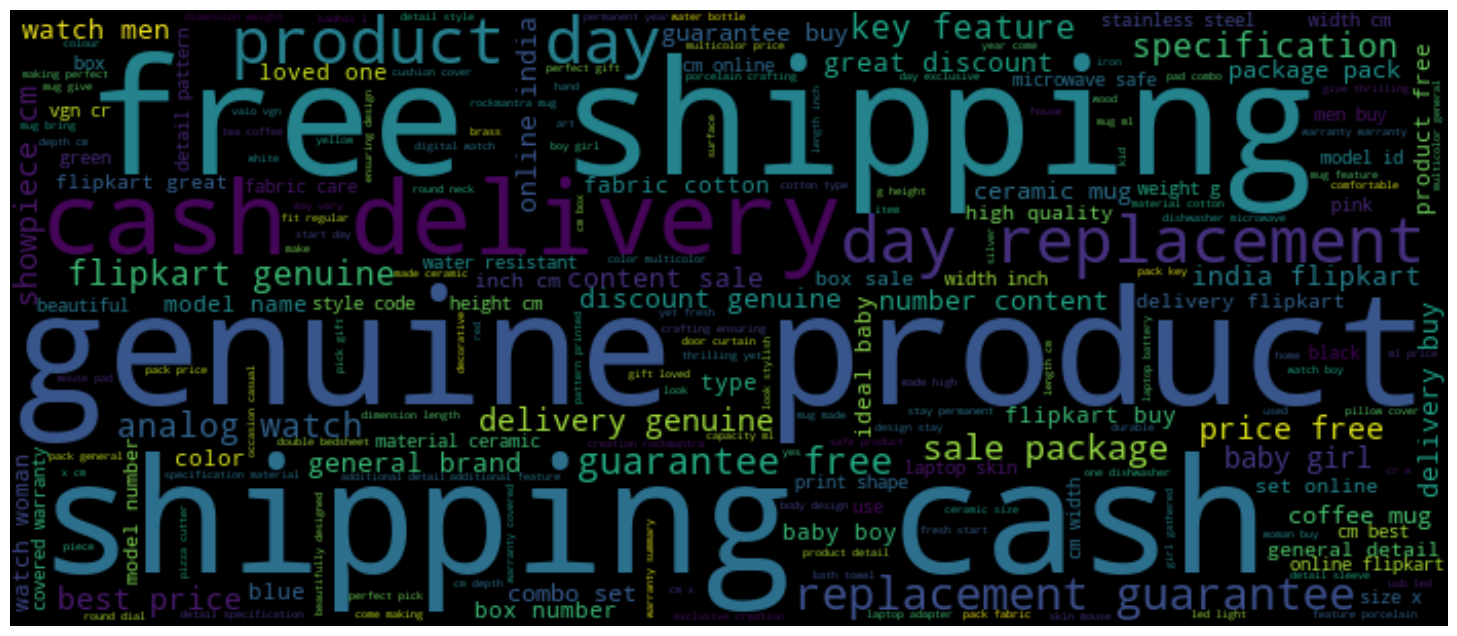

In [36]:
# Crée une liste vide appelée 'words' pour stocker les mots des descriptions sans les mots vides (STOPWORDS)
words = []
# Parcours chaque description dans la colonne 'clean_description' du DataFrame df_clean
for message in df_clean['clean_description']:
     # La liste en compréhension est utilisée pour sélectionner les mots qui ne sont pas dans la liste STOPWORDS
    # Ces mots sélectionnés sont ensuite ajoutés à la liste 'words'
    words.extend([word for word in message.split() if word not in STOPWORDS])
    
 # Utilise WordCloud pour générer un nuage de mots       
wordcloud = WordCloud(width = 700, height = 300).generate(" ".join(words))

# Affiche le nuage de mots
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Supprime les axes
plt.show()

(-0.5, 399.5, 199.5, -0.5)

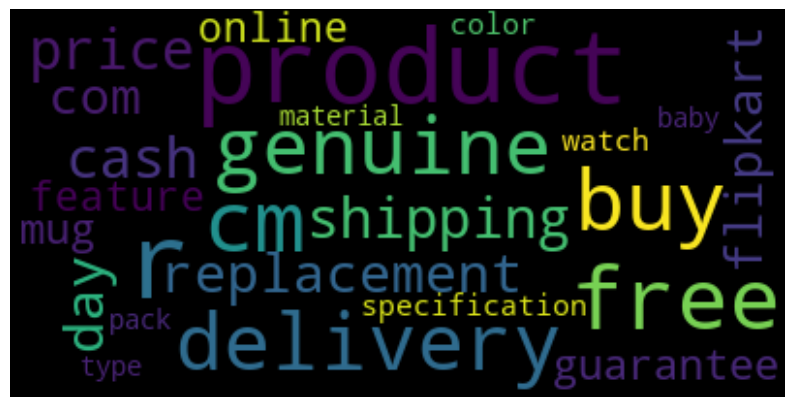

In [37]:
# Importe la classe WordCloud et ImageColorGenerator de la bibliothèque WordCloud
from wordcloud import WordCloud, ImageColorGenerator

# Crée une instance de WordCloud avec des paramètres spécifiques
wc=WordCloud(stopwords=stop_words,
             collocations=False, 
             max_font_size=55,
             max_words=25, 
             background_color="black")
# Génère le nuage de mots en utilisant les descriptions nettoyées et prétraitées
wc.generate(' '.join(df_clean['clean_description']))
# Crée une figure pour le graphique avec une taille spécifiée
plt.figure(figsize=(10,12))
# Affiche le nuage de mots généré
plt.imshow(wc, interpolation="bilinear")
# Supprime les axes
plt.axis("off")

In [38]:
# Crée une copie du DataFrame df_clean sous le nom df_f
df_f=df_clean.copy()
# Affiche les deux premières lignes de la copie df_f
df_f.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categorie,categorie2,res,clean_description,res_clean
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,230,key feature elegance polyester multicolor abst...,152
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,74,specification sathiyas cotton bath towel bath ...,62


In [39]:
#df_f = df_clean.iloc[:,[8,17,15]]

In [40]:
#df_f

In [41]:
from sklearn.preprocessing import LabelEncoder
# Crée une instance de LabelEncoder
le = LabelEncoder()
# Applique l'encodage aux étiquettes de catégorie ('categorie') dans le DataFrame df_f
df_f['labels']= le.fit_transform(df_f['categorie'])
# Affiche le DataFrame df_f avec la nouvelle colonne 'labels' contenant les valeurs numériques encodées
df_f

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,product_rating,overall_rating,brand,product_specifications,categorie,categorie2,res,clean_description,res_clean,labels
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,230,key feature elegance polyester multicolor abst...,152,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,74,specification sathiyas cotton bath towel bath ...,62,0
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,215,key feature eurospa cotton terry face towel se...,154,0
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,145,key feature santosh royal fashion cotton print...,114,4
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,214,key feature jaipur print cotton floral king si...,153,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,431,oren empower extra large self adhesive sticker...,226,0
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,303,wallmantra large vinyl sticker sticker pack pr...,154,0
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00

In [42]:
# Affiche les classes (étiquettes de catégorie) encodées par l'instance de LabelEncoder
print(le.classes_)

['Baby Care' 'Beauty and Personal Care' 'Computers'
 'Home Decor & Festive Needs' 'Home Furnishing' 'Kitchen & Dining'
 'Watches']


In [44]:
# Sauvegarde du DataFrame df_f dans un fichier CSV
df_f.to_csv(r'my_df.csv', index=False)